**Reinforcement Learning**

GRID WORLD - TD(0) "http://www.mit.edu/~jnt/Papers/J075-99-bvr-av_td.pdf"


        +---+---+---+---+---+
        | 1 | 2 | 3 | 4 | 5 |
        +---+---+---+---+---+
        | 6 | 7 | 8 | 9 |10 |
        +---+---+---+---+---+
        |11 |12 |13 |14 |15 |
        +---+---+---+---+---+
        |16 |17 |18 |19 |20 |
        +---+---+---+---+---+
        |21 |22 |23 |24 |25 |
        +---+---+---+---+---+
                              5x5

In [1]:
from __future__ import division ## 
import numpy as np
import pandas as pd
import tqdm
import random

In [2]:
_ACTION_LIST = ['N', 'E', 'W', 'S']
_GRID_WORLD_DIMENSIONS = [5, 5]  # [row, cols]

_SPECIAL_POSITION_A = [1, 0]
_SPECIAL_POSITION_A_DASH = [1, 2]

_SPECIAL_POSITION_B = [3, 0]
_SPECIAL_POSITION_B_DASH = [3, 3]

_num_of_iterations = 1000

In [3]:
class gridworld():
    def __init__(self, init_state, J_t, V_t, phi, df=pd.DataFrame(columns = ['t', 'd', 'J', 'V'])):
        self.state = init_state
        self.J_t = J_t
        self.V_t = V_t
        self.phi = phi
        self.df = df


    def print_gridworld(self):
        print("+---+---+---+---+---+")
        for i in range(0, _GRID_WORLD_DIMENSIONS[0]):
            line = "|"
            for j in range(0, _GRID_WORLD_DIMENSIONS[1]):
                if self.state == [j, i]:
                    line += " o |"
                elif _SPECIAL_POSITION_A == [j, i]:
                    line += " A |"
                elif _SPECIAL_POSITION_B == [j, i]:
                    line += " B |"
                elif _SPECIAL_POSITION_A_DASH == [j, i]:
                    line += " a |"  # taking small a as a_dash
                elif _SPECIAL_POSITION_B_DASH == [j, i]:
                    line += " b |"  # taking small b as b_dash
                else:
                    line += "   |"

            print(line)
            print("+---+---+---+---+---+")


    def action_on_policy(self):
        "equiprobable action policy"
        return _ACTION_LIST[random.randint(0, len(_ACTION_LIST)-1)]


    def get_reward_next_state(self, action):
        state = self.state
        if action == 'N':
            next_state = [state[0], state[1]-1]
        elif action == 'E':
            next_state = [state[0]+1, state[1]]
        elif action == 'W':
            next_state = [state[0]-1, state[1]]
        elif action == 'S':
            next_state = [state[0], state[1]+1]

        # normal case reward = 0
        reward = 0

        if state == _SPECIAL_POSITION_A:
            reward = 10
            next_state = _SPECIAL_POSITION_A_DASH

        elif state == _SPECIAL_POSITION_B:
            reward = 5
            next_state = _SPECIAL_POSITION_B_DASH

        # if next state is going out of bounds, reward = -1
        elif next_state[0] in (-1, _GRID_WORLD_DIMENSIONS[0]) or next_state[1] in (-1, _GRID_WORLD_DIMENSIONS[1]):
            reward = -1
            next_state = state

        self.state = next_state
        return reward


    def update_scalar_TD0_terms(self, t, reward, s_t, s_tplus_1):
        alpha_t = (1/((t/50)+1))
        J_t = self.J_t
        V_t = self.V_t
        
        J_tplus_1 = J_t + alpha_t * (reward - J_t)
        d_t = reward - J_tplus_1 + (V_t * phi[s_tplus_1[1], s_tplus_1[0]]) - (V_t * phi[s_t[1], s_t[0]])
        V_tplus_1 = V_t + alpha_t * d_t * phi[s_t[1], s_t[0]]
        
        # append respective values onto a df
        self.df = self.df.append({'t':t, 'd':d_t, 'J':J_t, 'V':V_t}, ignore_index=True) 
        
        self.J_t = J_tplus_1
        self.V_t = V_tplus_1

    def update_vector_TD0_terms(self, t, reward, s_t, s_tplus_1):
        alpha_t = (1/((t/50)+1))
        J_t = self.J_t
        V_t = self.V_t
        
        J_tplus_1 = J_t + alpha_t * (reward - J_t)
        d_t = reward - J_tplus_1 + (V_t * phi) - (V_t * phi) # assuming phi is constant for S_t and S_tplus, the latter terms cancel out
        V_tplus_1 = V_t + alpha_t * d_t * phi
        
        # append respective values onto a df
        self.df = self.df.append({'t':t, 'd':d_t, 'J':J_t, 'V':V_t}, ignore_index=True) 
        
        self.J_t = J_tplus_1
        self.V_t = V_tplus_1


    def instance_iteration(self, t, method):
        #print('curr_state: ')
        #self.print_gridworld()
        s_t = self.state
        
        action = self.action_on_policy()
        reward = self.get_reward_next_state(action)
        
        s_tplus_1 = self.state
        #print('next_state: ')
        #self.print_gridworld()
        #print("\naction taken: " + action)
        #print("reward received: " + str(reward) + "\n")
        if method=='vector':
            self.update_vector_TD0_terms(t, reward, s_t, s_tplus_1) # updating TD terms
        elif method=='scalar':
            self.update_scalar_TD0_terms(t, reward, s_t, s_tplus_1) # updating TD terms
        #print('------------------------\n')


In [4]:
def simulate_for_given_params(params_for_init_state, method):
    list_of_td_terms_df = [] # for different initial states

    for init_state, kwargs in params_for_init_state.items():
        game_instance = gridworld(**kwargs) ## initialize grid world
        for i in tqdm.tqdm(range(1, _num_of_iterations+1)): ## simulation - time progressing
            game_instance.instance_iteration(i, method)
        df = game_instance.df
        df['init_state'] = init_state
        list_of_td_terms_df.append(df)

    td0_grid_simulation_data_df = pd.concat(list_of_td_terms_df)
    return td0_grid_simulation_data_df

In [5]:
def Vt_plot_to_power_25(V):
    return_value = 0
    for i in range(1, 26):
        return_value += np.power(V, i)
    return return_value/25

In [6]:
# Case 1 for phi matrix being 1 at position 5 and 0 elsewhere
# V_t and phi both vectors

J_t = 0
V_t = np.zeros(25)

phi = np.zeros(25) 
phi[4] = 1 ## at position 5

# 3 initial states - 13, 2, 25

init_state = [2,2] ## initial_state S0 = 13
params_for_init_state = {'13':{'init_state':init_state, 'J_t':J_t, 'V_t':V_t, 'phi':phi}}

init_state = [1,0] ## initial_state S0 = 2
params_for_init_state['2'] = {'init_state':init_state, 'J_t':J_t, 'V_t':V_t, 'phi':phi}

init_state = [4,4] ## initial_state S0 = 25
params_for_init_state['25'] = {'init_state':init_state, 'J_t':J_t, 'V_t':V_t, 'phi':phi}

In [7]:
td0_grid_simulation_data_df = simulate_for_given_params(params_for_init_state, method='vector')

100%|██████████| 1000/1000 [00:05<00:00, 179.62it/s]


In [8]:
print(td0_grid_simulation_data_df.head())
print('unique init_states', td0_grid_simulation_data_df['init_state'].unique())

   t                                                  d  J  \
0  1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0   
1  2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0   
2  3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0   
3  4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0   
4  5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0   

                                                   V init_state  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         13  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         13  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         13  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         13  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         13  
unique init_states ['13' '2' '25']


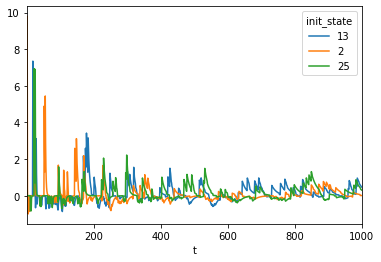

In [10]:
## J_t as a function of t
td0_grid_simulation_data_df.pivot(index='t', columns='init_state', values='J').plot()

In [11]:
## converting V_t vector to scalar by taking a mean
td0_grid_simulation_data_df['V'] = td0_grid_simulation_data_df['V'].apply(lambda x: sum(x)/len(x))

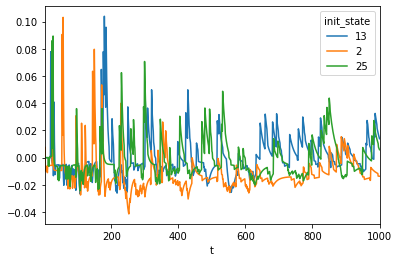

In [12]:
## V_t as a function of t
td0_grid_simulation_data_df.pivot(index='t', columns='init_state', values='V').plot()

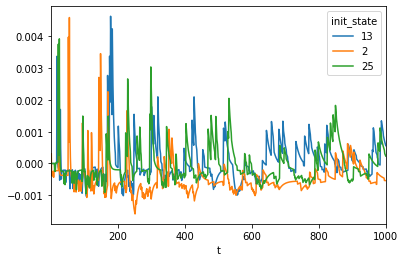

In [13]:
td0_grid_simulation_data_df['Vt_plot_to_power_25'] = td0_grid_simulation_data_df['V'].apply(Vt_plot_to_power_25) ## calculate (V_t + V_t**2 + .. + V_t**25)/25
## (V_t + V_t**2 + .. + V_t**25)/25 as a function of t
td0_grid_simulation_data_df.pivot(index='t', columns='init_state', values='Vt_plot_to_power_25').plot()

In [14]:
# Case 2 for phi matrix being s/25, where s is the state cell number
# scalar values
J_t = 0
V_t = 0

phi = np.zeros([5, 5])
temp_var = 1
for j in range(0,5):
    for i in range(0,5):
        phi[i, j] = temp_var/25
        temp_var += 1
del temp_var

# 3 initial states - 13, 2, 25

init_state = [2,2] ## initial_state S0 = 13
params_for_init_state = {'13':{'init_state':init_state, 'J_t':J_t, 'V_t':V_t, 'phi':phi}}

init_state = [1,0] ## initial_state S0 = 2
params_for_init_state['2'] = {'init_state':init_state, 'J_t':J_t, 'V_t':V_t, 'phi':phi}

init_state = [4,4] ## initial_state S0 = 25
params_for_init_state['25'] = {'init_state':init_state, 'J_t':J_t, 'V_t':V_t, 'phi':phi}

In [15]:
td0_grid_simulation_data_df = simulate_for_given_params(params_for_init_state, method='scalar')

100%|██████████| 1000/1000 [00:01<00:00, 604.20it/s]


In [16]:
print(td0_grid_simulation_data_df.head())
print('unique init_states', td0_grid_simulation_data_df['init_state'].unique())

     t    d    J    V init_state
0  1.0  0.0  0.0  0.0         13
1  2.0  0.0  0.0  0.0         13
2  3.0  0.0  0.0  0.0         13
3  4.0  0.0  0.0  0.0         13
4  5.0  0.0  0.0  0.0         13
unique init_states ['13' '2' '25']


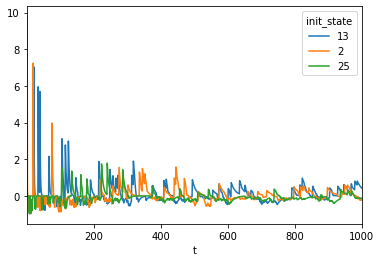

In [17]:
## J_t as a function of t
td0_grid_simulation_data_df.pivot(index='t', columns='init_state', values='J').plot()

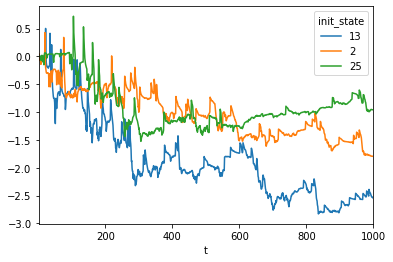

In [18]:
## V_t as a function of t
td0_grid_simulation_data_df.pivot(index='t', columns='init_state', values='V').plot()

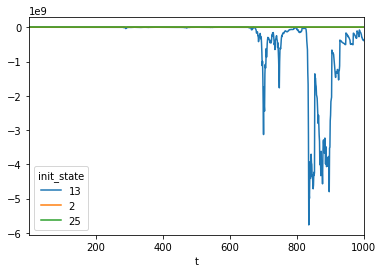

In [19]:
td0_grid_simulation_data_df['Vt_plot_to_power_25'] = td0_grid_simulation_data_df['V'].apply(Vt_plot_to_power_25) ## calculate (V_t + V_t**2 + .. + V_t**25)/25
## (V_t + V_t**2 + .. + V_t**25)/25 as a function of t
td0_grid_simulation_data_df.pivot(index='t', columns='init_state', values='Vt_plot_to_power_25').plot()